# Exercise # 3

Instructor for Assignment:
 - George Ciubotariu: george.ciubotariu@uni-wuerzburg.de
 - Kindly post your questions here: https://wuecampus.uni-wuerzburg.de/moodle/mod/forum/view.php?id=3093380

Complete implementation and analysis of building LeNet-5 model from scratch in PyTorch and training on MNIST dataset.

In this exercise, you will learn about Convolutional Neural Networks by implementing some layers (focusing mostly on their forward and backpropagation functions). You will also complete the code for visualizations and understanding the inner mechanics of the CNNs.

Note: Notation may not be the same as the lecture. In that case, kindly open an issue at the forum. DO NOT CHANGE THE CODE SKELETONS, JUST COMPLETE THE MISSING PARTS, as instructed.

Pre-requistes:
0. Preferrably, use Google Colab, or a conda environment for easier libraries and dependencies management
1. Python >= 3.8
2. [torch (PyTorch)](https://pytorch.org/get-started/locally/) -> PyTorch is a library for working with tensors on GPUs (or CPUs; you do not need a GPU for the exericses). This is **the** library for implementing and training deep learning models.
3. [Numpy](https://numpy.org/install/) -> Library for working with tensors. It is CPU-only.
4. [maplotlib](https://pypi.org/project/matplotlib/) -> Library for creating visualizations. You will not be using this library but it is important to install it.
5. [pandas](https://pypi.org/project/pandas/) -> Powerful data structures for data analysis, time series, and statistics.
6. [seaborn](https://pypi.org/project/seaborn/) -> Statistical data visualization library.
7. [sklearn](https://pypi.org/project/scikit-learn/) -> ML, data mining, and stats library with a lot of mathematical tools.
8. [torchinfo](https://pypi.org/project/torchinfo/) -> Model summary in PyTorch, based off of the original torchsummary.
9. [torchmetrics](https://pypi.org/project/torchmetrics/) -> PyTorch native Metrics.

<font color="red">
HOMEWORK:
</font>
</br>
<font color="red">
- implement LeNet using Pytorch, and use the existing scripts to train the model and evaluate it.
</font>
</br>
<font color="red">
- implement layers from scratch and test your implementation using the existing tests.
</font>

#Dataset Preparation

Among the most well-known datasets in Computer Vision, there is MNIST (Modified National Institute of Standards and Technology database) dataset for digit recognition, introduced in:

> Y. Lecun, L. Bottou, Y. Bengio and P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, Nov. 1998, doi: 10.1109/5.726791.


It has a training set of 60,000 examples, and a test set of 10,000 examples.
The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio.
The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm.
The images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

In this section, you have to run the code snippets, download the dataset using the `torchvision` library (so that you do not have to bother about I/O-level operations on binary data, or organizing and structuring the data). Then, we see check the inner structure of the dataset, and its data types. After coming to grips with the dataset, we follow the basic pipeline of transforming and processing the data, so that an abstract structure may feed it into a CNN.

You may notice from the first few lines of dataset analysis that you are working with PIL (`Pillow` lib) images and integer labels (from 0 to 9, representing the digit).

##Dowload the dataset

In [1]:
from torchvision import datasets

In [2]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True)

##Analyze the dataset

In [3]:
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test)

In [4]:
class_names = train_val_dataset.classes
class_names[0]

'0 - zero'

In [5]:
class_index = train_val_dataset.class_to_idx
class_index

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [6]:
img, label = train_val_dataset[0]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 5)

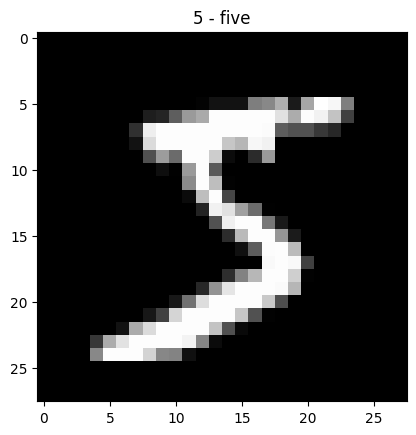

In [7]:
import matplotlib.pyplot as plt

plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

So far, we have seen how an image looks to humans, and how the data is structured in this dataset, namely in tuples of 28 by 28 pixels PIL images and their corresponding labelled digit.

We are now going to how the images are represented, by displaying the pixel values overlaid onto each of them.

The code is relatively straightforward. Since pixels are represented as 8bit values in memory, we have absolute black 0 and absolute white 255.
In the figure below we are displaying the luminosity of a pixel and, in order to see their actual numeric value written on top of them, the writing must be inversely proportional to their brightness.

In [8]:
import numpy as np

def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')  # gray_reversed
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)

/tmp/ipykernel_555/1572773032.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('gray_r')  # gray_reversed


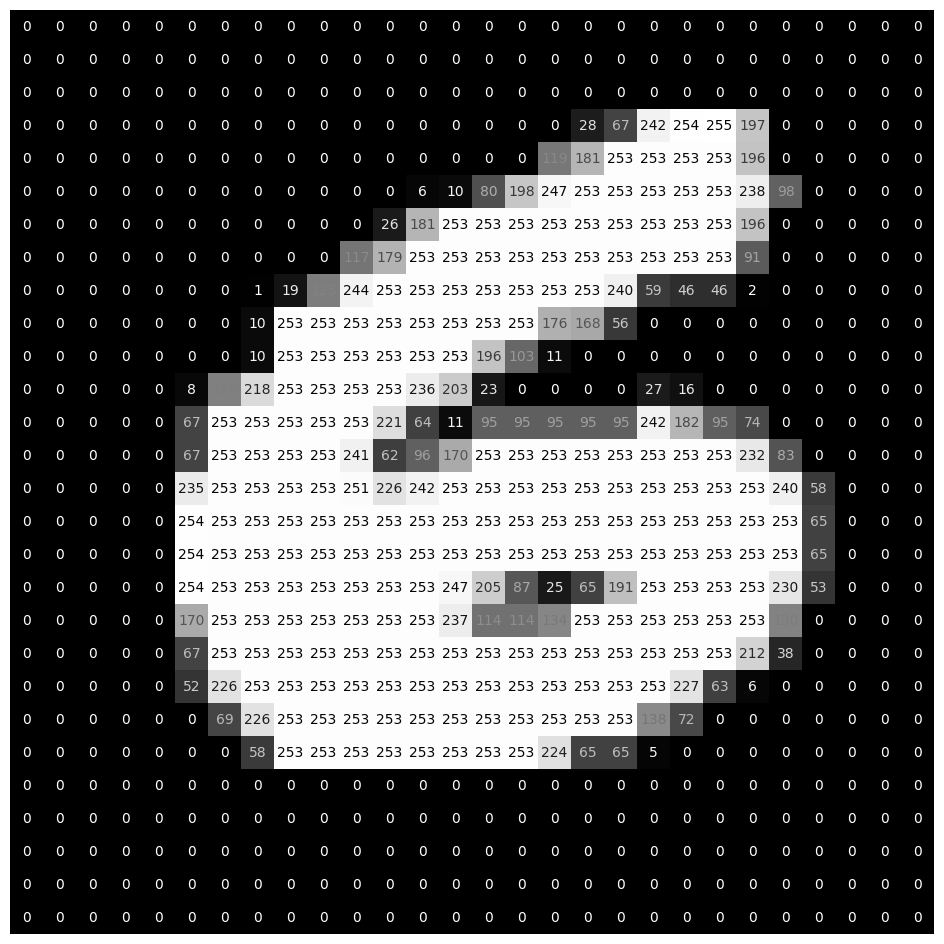

In [9]:
import torch

torch.manual_seed(42)

fig = plt.figure(figsize = (12,12))
ax0 = fig.add_subplot(1, 1, 1)

rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()

img0 = train_val_dataset.data[rand_ind]
img0 = img0.numpy()
img_pixel_superimpose(img0, ax0)

Lastly, we consider a sample slice of the dataset and display the digits and their labels, so that we gain a better understanding of the complexity of the problem we are dealing with.

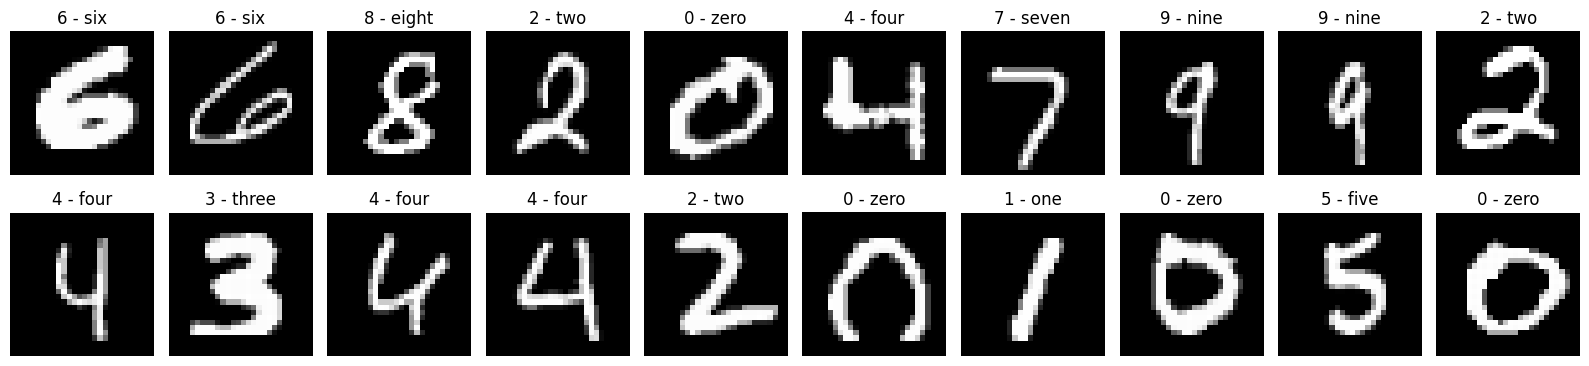

In [10]:
torch.manual_seed(42)  # Search on the internet why '42' is special

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_val_dataset), size=[1]).item()
    img, lab = train_val_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[lab]}")
    plt.axis(False)
    plt.tight_layout()

##Transform the dataset

Now that we have understood the basics of our dataset, we are preparing the data for the steps to follow, namely training a LeNet model on the dataset.

Since we are going to follow a Pytorch implementation, we are working with `torch` and its `Tensor` data structure.

We follow about the same steps as before and notice the differences.

ToTensor - converts the before PIL image to a Pytorch tensor.
You may take a deeper look into what Tensors are. In short, they are higher-dimension matrices, but that is not the complete definition.

Normalize - grants stability in the optimization process, promoting faster convergence during gradient-based training

Split - fundamental to the development of robust and reliable machine learning models, we have to test the generalization ablities of our model to perform on unseen data. That means that we may only train on the *training split*, then perform the inference on the *validation split*. After we have achieved a satisfying performance on it, we submit the model to be benchmarked on the *testing split*.
In most scenarios, the test data is either not available, or we do not have access to it, so we cannot purposely overfit on it.

Dataloader - `torch.utils.data` has already implemented containers for data. They are usually meant to be used with a common iterator API. Depending on the dataloader policy, some implementations may allow random shuffling, different batch sizes(*), or drop the last incomplete batch if desired.

(*): Since in Deep Learning the resources are always limited, and it is not feasible to load all the dataset in the RAM at once, we may only use several data instances at a time, therefore splitting the dataset into batches that may fit in the memory and can be processed in reasonable time.

In [11]:
from torchvision import transforms

###ToTensor()

In [12]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [13]:
img, lab = train_val_dataset[0]
img, lab

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [14]:
img.min(), img.max()  # The ToTensor() transformation scaled down 0-255 --> 0-1

(tensor(0.), tensor(1.))

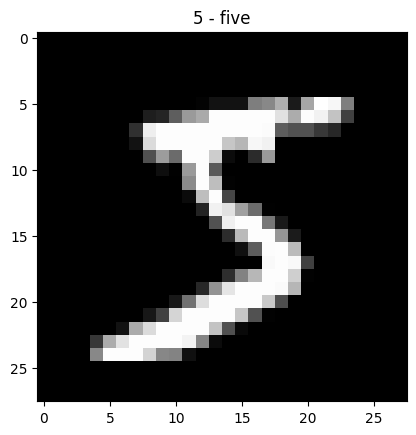

In [15]:
plt.imshow(img.squeeze_(), cmap='gray')
plt.title(f"{class_names[lab]}");

###Normalization

In [16]:
# Calculate mean and std

imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)
print(imgs.shape)

torch.Size([60000, 1, 28, 28])


In [17]:
mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
mean, std

(tensor([0.1307]), tensor([0.3081]))

In [18]:
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])
mnist_transforms


Compose(
    ToTensor()
    Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
)

In [19]:
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ))

In [20]:
img, label = train_val_dataset[0]
img, label

(tensor([[[-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
           -0.4241, -0.4241, -0.424

In [21]:
img.min(), img.max()

(tensor(-0.4241), tensor(2.8215))

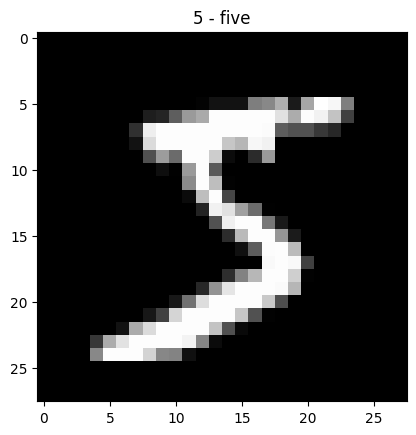

In [22]:
plt.imshow(img.squeeze_(), cmap='gray')
plt.title(f"{class_names[label]}");

##Split dataset into Train/Val/Test

In [23]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
train_dataset, val_dataset

(<torch.utils.data.dataset.Subset at 0x7efccf4459f0>,
 <torch.utils.data.dataset.Subset at 0x7efccf445780>)

In [24]:
len(train_dataset), len(val_dataset), len(test_dataset)

(54000, 6000, 10000)

In [25]:
len(train_dataset), len(train_dataset.dataset)  # Remember train_dataset.dataset access parent train_val_dataset

(54000, 60000)

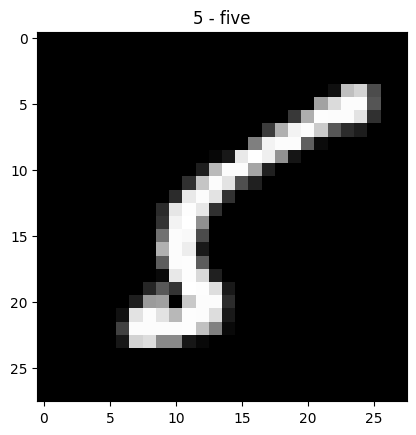

In [26]:
# Validate train dataset is working fine
img, label = train_dataset[0]
plt.imshow(img.squeeze_(), cmap='gray')
plt.title(f"{class_names[label]}");

##Dataloader preparation

In [27]:
from torch.utils.data import DataLoader

In [28]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7efccf647730>,
 <torch.utils.data.dataloader.DataLoader at 0x7efccf621750>)

In [29]:
img, label = train_dataloader.dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

In [30]:
no_train_batches = len(train_dataloader.dataset) / train_dataloader.batch_size
no_val_batches = len(val_dataloader.dataset) / val_dataloader.batch_size
no_test_batches = len(test_dataloader.dataset) / test_dataloader.batch_size

# Let's see no of batches that we have now with the current batch-size
no_train_batches, no_val_batches, no_test_batches

(1687.5, 187.5, 312.5)

In [31]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)   # Actual lengths show wrapping at the end

(1688, 188, 313)

#Model Architecture, Construct Training & Evaluation Pipeline

<font color="red">TASK: Implement LeNet:</font>
</br>
<font color="red">Considering the following model scheme, write your own code inside the `__init__` and `forward` functions below.</font>
</br>
<font color="red">you must use ONLY layers and activation functions from the `torch.nn` module!</font>
</br>
<font color="red">in the `forward` function return the output value of the CNN by calling the blocks(*) initialized in `__init__`.</font>

(*): Blocks can a grouping of several layers and activation functions in a sequential way.

- Feed-forward manner

A. feature extractor / feature compression
- Block 1. 5x5 Conv outputting 6 channels + Tanh activation + 2x2 AvgPool
- Block 2. 5x5 Conv outputting 16 channels + Tanh activation + 2x2 AvgPool
* **mind that you should get a feature map resolution of 5x5 here, at the end**

B. classifier
- Adapt 0. Flatten kernel representation of the multidimensional tensor feature maps
- Block 1. Fully-connected outputting 120 features + Tanh activation function
- Block 2. Fully-connected outputting  84 features + Tanh activation function
- Block 3 (output). Fully-connected that returns the probabilities of each of the 10 digits to be the actual one.

The beauty of Pytorch is that once you use their pre-defined layers and functions, there is no need to explicitly implement the backpropagation function.
You're good to go unless you design your own intricate activation functions that may not be derivable in specific points, or the autograd may face issues computing the gradient.

##LeNet5_V1

In [32]:
from torch import nn

In [33]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super(LeNet5V1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 120, bias=True),
            nn.Tanh(),
            nn.Linear(120, 84, bias=True),
            nn.Tanh(),
            nn.Linear(84, 10, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [34]:
model_lenet5v1 = LeNet5V1()
model_lenet5v1

LeNet5V1(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

##Model summary

`torchinfo` will offer us a better structured report of how our model looks like. Moreover, it displays the number of trainable and total parameters, which is crucial in research for benchmarking a model.

It performs a dry run, given a batch of a single 28x28 grayscale image.
data format: (batch_size, number_of_channels, height, width).
This format differs from one framework to another, and it is usually specified in a metadata file, in an internal config parameter, or passed as an explicit format in a function.
If there are multiple channels, e.g., 3 or 4, we may be dealing with RGB or RGBA images, as well as YUV, RGGB or RGBD and multiple other data formats.

In [35]:
#pip install torchinfo

In [36]:
from torchinfo import summary

In [37]:
summary(model=model_lenet5v1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

/home/jovyan/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─Tanh (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
│    └─Conv2d (3)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─Tanh (4)                          [1, 16, 8, 8]        [1, 16, 8, 8]        --                   --
│    └─AvgPool2d (5)                     [1, 16, 8, 8]        [1, 16, 4, 4]        --                   --
├─Sequential (classifi

##Loss, Optimizer, Metrics

`torchmetrics` - we are going to use the Accuracy metric without bothering to implement it. This will be later useful when logging results.

`tensorboard` - The library's SummaryWriter allows for configurable graphical representations without much effort.

In [38]:
#pip install torchmetrics

In [39]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5v1.parameters(), lr=0.001)

accuracy = Accuracy(task='multiclass', num_classes=10)

##Train model

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "LeNet5V1"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_lenet5v1 = model_lenet5v1.to(device)

EPOCHS = 12

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        model_lenet5v1.train()

        y_pred = model_lenet5v1(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_lenet5v1.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model_lenet5v1(X)

            loss = loss_fn(y_pred, y)
            val_loss += loss.item()

            acc = accuracy(y_pred, y)
            val_acc += acc

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")


##Save model

Utils I/O for persistence of trained checkpoints - saves you a lot of time and avoids total loss in case of fatal erorrs (data server becomes unreachable and dataloader fails, therfore causing a chain-reaction-like failure)

In [41]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5_v1_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [42]:
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_lenet5v1.state_dict(), f=MODEL_SAVE_PATH)

Saving the model: models/lenet5_v1_mnist.pth


##Load model

In [43]:
model_lenet5_v1_mnist_loaded = LeNet5V1()
model_lenet5_v1_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))
model_lenet5_v1_mnist_loaded

LeNet5V1(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

##Evaluate model

Benchmarking on the final test set.

We only perform this step after being fully confident that the performance validation set would not get any better using the chosen methodology. Again, We raise awareness that the *testing set* is not for abusively overfitting the models. Usually, in the literature, one model is trained on the train + validation sets and then submitted to be tested on multiple test sets from different datasets, so that the generality of the model is not compromised by only achieving impressive results on a single specific dataset.

In [44]:
test_loss, test_acc = 0, 0

model_lenet5_v1_mnist_loaded.to(device)

model_lenet5_v1_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet5_v1_mnist_loaded(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.04196| Test acc:  0.98682


In [45]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = []
y_test = []
for x, y in test_dataloader:
  y_pred.append(model_lenet5_v1_mnist_loaded(x.to(device)).cpu().detach().numpy())
  y_test.append(y.detach().numpy())

y_pred = np.concatenate(y_pred)
y_test = np.concatenate(y_test)

Confusion matrix

This evaluation method visually displays us the correctly classified digits on the main diagonal and everything else is either a mistaken predictions.

For further reference, please use: https://en.wikipedia.org/wiki/Template:Diagnostic_testing_diagram

However, in this resource, it is considered that the data is binary. In our multi-class case we have to use something like this: https://www.researchgate.net/figure/Confusion-matrix-for-multi-class_fig1_342719313

Classification accuracy: 0.9868


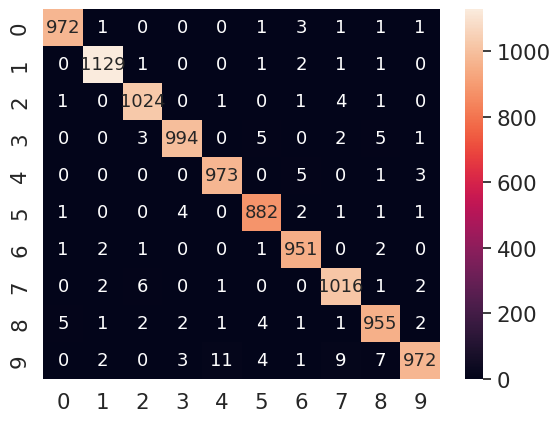

In [46]:
# now, we will build a function that outputs the accuracy on the test split inputs,
# in text format and will plot a confusion matrix built on the model predictions
def plot_evaluation_report(ys, preds):
  predictions = np.argmax(preds, axis=1)

  print("Classification accuracy: {}".format(accuracy_score(ys, predictions)))
  clf_confusion_matrix = confusion_matrix(ys, predictions)
  classes = [str(i) for i in range(10)]

  df_cmatrix = pd.DataFrame(clf_confusion_matrix, classes, classes)
  df_cmatrix.style.format("{:.1f}")

  sn.set(font_scale=1.4)
  sn.heatmap(df_cmatrix, annot=True, annot_kws={"size": 13}, fmt='g')


# evaluate the loaded model
plot_evaluation_report(y_test, y_pred)

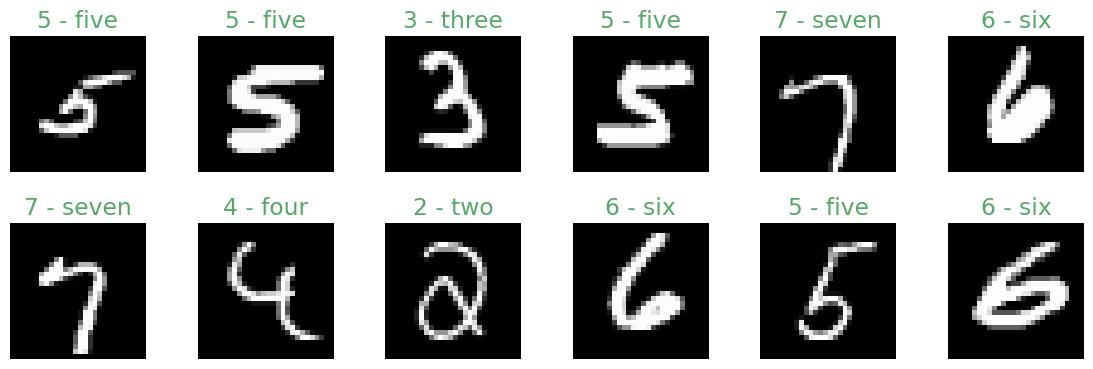

In [47]:
# See random images with their labels
torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model_lenet5_v1_mnist_loaded(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g')
    else:
        plt.title(class_names[label_pred], color='r')
    plt.axis(False)
    plt.tight_layout();

##Visualize model metrics

`tensorboard` is a state-of-the-art visualization toolkit for machine learning experimentation, for easy automatized visualizations of the models' progress over multiple epochs. Metrics must be registered to be recorded and then the configurable interface allows us to observe clear reports and gain better insight into how the models actually learn and perform.

In [48]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir="./runs/" --port 6006 --host 0.0.0.0 --load_fast=false

##Explainable AI (XAI)

Explainable AI is a set of processes and methods that allows human users to comprehend and trust the results and output created by machine learning algorithms.

Explainable AI is used to describe an AI model, its expected impact and potential biases. It helps characterize model accuracy, fairness, transparency and outcomes in AI-powered decision making. Explainable AI is crucial for an organization in building trust and confidence when putting AI models into production. AI explainability also helps an organization adopt a responsible approach to AI development.

In the following code snippets we are going to take a look over integrated gradients and feature map activations throughout the model.

###Integrated Gradients visualization

In [50]:
#pip install captum

In [51]:
from captum.attr import IntegratedGradients

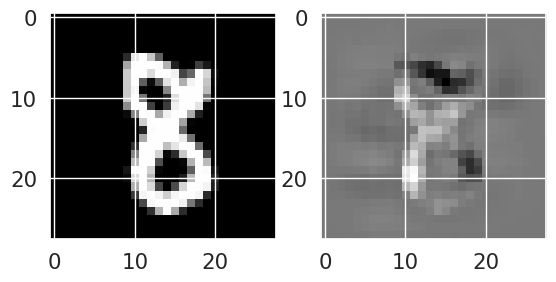

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(108)

random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
img, label = test_dataset[random_idx]
img = img.to(device)

# Instantiate an IntegratedGradients object for the model
ig = IntegratedGradients(model_lenet5_v1_mnist_loaded)

# Compute the attribution scores for the random image
attr, delta = ig.attribute(img.unsqueeze(0), target=label, return_convergence_delta=True)

# Visualize the attribution scores
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img.permute(1, 2, 0).to('cpu'), cmap='gray')
ax[1].imshow(attr[0][0].detach().to('cpu').numpy(), cmap='gray')

###Feature maps visualization

####Define layer

In [53]:
intermediate_layer = model_lenet5_v1_mnist_loaded.features[2]
print(intermediate_layer)

AvgPool2d(kernel_size=2, stride=2, padding=0)


####Hook setup

In [54]:
# Hook function
def hook_fn(module, input, output):
    global layer_output
    layer_output = output

In [55]:
# Register the hook
handle = intermediate_layer.register_forward_hook(hook_fn)

####Input images

#####Image

In [56]:
import torchvision.transforms as transforms

def viz_plain(layer_num, img, model, device):

    # transforms
    transforms_img = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    img = transforms_img(img).unsqueeze_(dim=0)

    # device-agnostic
    model = model.to(device)
    img = img.to(device)

    # Hook function
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)

    layer = model_lenet5_v1_mnist_loaded.features[layer_num]
    handle = layer.register_forward_hook(hook_fn)

    # Forward pass the image through the model
    model.eval()
    with torch.inference_mode():
        preds = model(img)

    # Print the predicted class
    pred_cls_idx = preds.argmax(dim=1)
    print(pred_cls_idx.cpu().detach().numpy())

    # Plot the feature maps
    layer_output = feature_maps[0].squeeze()
    rows, cols = 4, 4  # this is the number of output feature maps
    fig = plt.figure(figsize=(12, 8))
    for i in range(1, (rows * cols) + 1):
        feature_map = layer_output[i-1, :, :].cpu().numpy()
        fig.add_subplot(rows, cols, i)
        plt.imshow(feature_map, cmap='viridis')
        # plt.tight_layout()
        plt.axis(False)

[7]


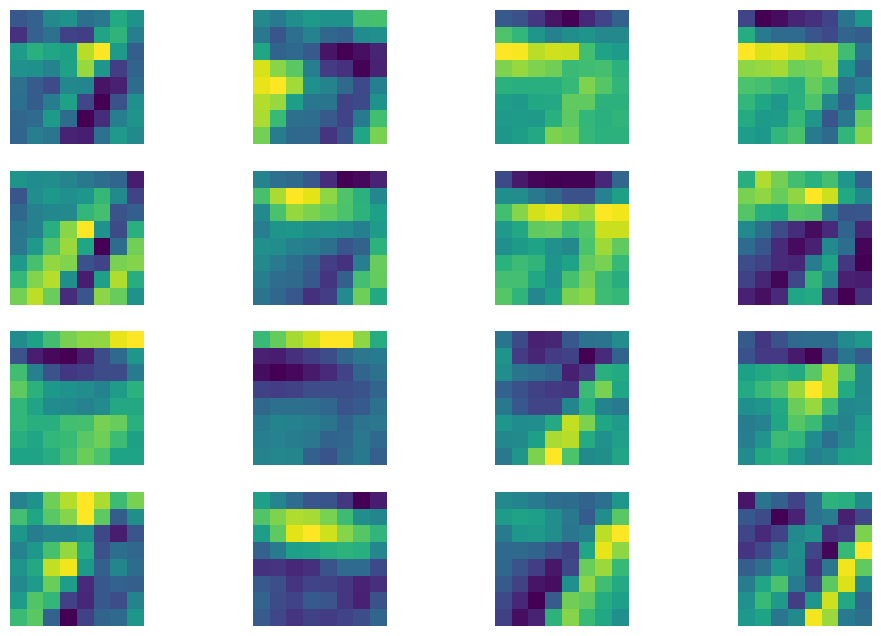

In [57]:
import PIL.Image as Image
img, label = test_dataset[0]  # any image
first_img = Image.fromarray(img.detach().numpy().squeeze())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

viz_plain(3, first_img, model_lenet5_v1_mnist_loaded, device)

#Implementation from Scratch

<font color="red">TASK: Implement from scratch using ONLY numpy:</font>
</br>
<font color="red">Initialize the layer-specific parameters in the `__init__` method.</font>
</br>
<font color="red">Process a given input in the `forward` method by </font>
</br>
<font color="red">Propagate the gradient inside the `backward` function below.</font>
</br>
<font color="red">You may define additional functions inside the classes if they would make your work easier.</font>


Now you are asked to implement the Flatten, Pooling, and Dropout layers that you might have come across in other learning journeys of yours.
<font color='red'>**The Convolution layer is not mandatory to be implemented. If you want to invest your time into learning more about it, you are welcome.**</font>
These are some of the most common types of layers, and they are absolutely necessary to be understood in-depth.

In this section we are offering the framework that should let you implement your layers and properly test them.

There are plenty of resources online, you are free to use any of them as long as you are able to understand them and explain everything to yourself.

##Functional Skeleton

In [58]:
def enum(*sequential, **named):
    # Enum definition for backcompatibility
    enums = dict(zip(sequential, range(len(sequential))), **named)
    return type('Enum', (), enums)

# Enum to encode the which phase a layer is in at the moment.
Phase = enum('train', 'test', 'validation')

class BaseLayer:

    def __init__(self):
        self.phase = Phase.train

    def forward(self, x):
        """ Return the result of the forward pass of this layer. Save intermediate results
        necessary to compute the gradients in the backward pass.
        """
        raise NotImplementedError('Base class - method is not implemented')

    def backward(self, error):
        """ Update the parameters/weights of this layer (if applicable),
        and return the gradient with respect to the input.
        """
        raise NotImplementedError('Base class - method is not implemented')

##Functional Elements

### Basic notation and terminology

We will work with the following notation and terminology:

- $\mathbf{X}$ and $\mathbf{x}$ represent the input,
- $\mathbf{W}$ and $\mathbf{w}$ the trainable weights/parameters and
- $\mathbf{Y}$ and $\mathbf{y}$ the output of a layer.
- $L$ represents the loss. Accordingly,
- $E_\mathbf{Y} = \frac{\partial L}{\partial \mathbf{Y}}$ is the error passed down from the subsequent layer,
- $E_\mathbf{W} = \frac{\partial L}{\partial \mathbf{W}}$ the error with respect to the weights and
- $E_\mathbf{X} = \frac{\partial L}{\partial \mathbf{X}}$ is the error with respect to the input.


####Helper Functions just for the sake of running the tests, don't mind them.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import struct
from pathlib import Path
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris, load_digits

class SoftMax:
    def __init__(self):
        self.prediction = None

    def forward(self, input_tensor, label_tensor):
        prediction = self.predict(input_tensor)
        indices = np.where(label_tensor == 1)
        loss = np.sum( - np.log(prediction[indices]))
        return loss

    def backward(self, label_tensor):
        indices = np.where(label_tensor == 1)
        error = self.prediction.copy()
        error[indices] = error[indices] - 1
        return error

    def predict(self, input_tensor):
        input_tensor = input_tensor - np.max(input_tensor)
        denominator = np.tile(np.sum(np.exp(input_tensor),axis = 1),(input_tensor.shape[1],1)).T
        prediction = np.exp(input_tensor)/denominator
        self.prediction = prediction
        return prediction

def gradient_check(layers, input_tensor, label_tensor):
    epsilon = 1e-5
    difference = np.zeros_like(input_tensor)

    activation_tensor = input_tensor.copy()
    for layer in layers[:-1]:
        activation_tensor = layer.forward(activation_tensor)
    layers[-1].forward(activation_tensor, label_tensor)

    error_tensor = layers[-1].backward(label_tensor)
    for layer in reversed(layers[:-1]):
        error_tensor = layer.backward(error_tensor)

    it = np.nditer(input_tensor, flags=['multi_index'])
    while not it.finished:
        plus_epsilon = input_tensor.copy()
        plus_epsilon[it.multi_index] += epsilon
        minus_epsilon = input_tensor.copy()
        minus_epsilon[it.multi_index] -= epsilon

        analytical_derivative = error_tensor[it.multi_index]

        for layer in layers[:-1]:
            plus_epsilon = layer.forward(plus_epsilon)
            minus_epsilon = layer.forward(minus_epsilon)
        upper_error = layers[-1].forward(plus_epsilon, label_tensor)
        lower_error = layers[-1].forward(minus_epsilon, label_tensor)

        numerical_derivative = (upper_error - lower_error) / (2 * epsilon)

        #print('Analytical: ' + str(analytical_derivative) + ' vs Numerical :' + str(numerical_derivative))
        normalizing_constant = max(np.abs(analytical_derivative), np.abs(numerical_derivative))

        if normalizing_constant < 1e-15:
            difference[it.multi_index] = 0
        else:
            difference[it.multi_index] = np.abs(analytical_derivative - numerical_derivative) / normalizing_constant

        it.iternext()
    return difference


def plot_difference(plot, description, shape, difference, directory):
    if plot:
        image = difference[0, :]
        image = image.reshape(shape)
        fig = plt.figure(description)
        plt.imshow(image)
        plt.colorbar()
        fig.savefig(os.path.join(directory, description + ".pdf"), transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close('all')


def gradient_check_weights(layers, input_tensor, label_tensor, bias):
    epsilon = 1e-5
    if bias:
        weights = layers[0].bias
    else:
        weights = layers[0].weights
    difference = np.zeros_like(weights)

    it = np.nditer(weights, flags=['multi_index'])
    while not it.finished:
        plus_epsilon = weights.copy()
        plus_epsilon[it.multi_index] += epsilon
        minus_epsilon = weights.copy()
        minus_epsilon[it.multi_index] -= epsilon

        activation_tensor = input_tensor.copy()
        if bias:
            layers[0].bias = weights
        else:
            layers[0].weights = weights
        for layer in layers[:-1]:
            activation_tensor = layer.forward(activation_tensor)
        layers[-1].forward(activation_tensor, label_tensor)

        error_tensor = layers[-1].backward(label_tensor)
        for layer in reversed(layers[:-1]):
            error_tensor = layer.backward(error_tensor)
        if bias:
            analytical_derivative = layers[0].get_gradient_bias()
        else:
            analytical_derivative = layers[0].get_gradient_weights()
        analytical_derivative = analytical_derivative[it.multi_index]

        if bias:
            layers[0].bias = plus_epsilon
        else:
            layers[0].weights = plus_epsilon
        plus_epsilon_activation = input_tensor.copy()
        for layer in layers[:-1]:
            plus_epsilon_activation = layer.forward(plus_epsilon_activation)

        if bias:
            layers[0].bias = minus_epsilon
        else:
            layers[0].weights = minus_epsilon
        minus_epsilon_activation = input_tensor.copy()
        for layer in layers[:-1]:
            minus_epsilon_activation = layer.forward(minus_epsilon_activation)

        upper_error = layers[-1].forward(plus_epsilon_activation, label_tensor)
        lower_error = layers[-1].forward(minus_epsilon_activation, label_tensor)

        numerical_derivative = (upper_error - lower_error) / (2 * epsilon)
        normalizing_constant = max(np.abs(analytical_derivative), np.abs(numerical_derivative))

        if normalizing_constant < 1e-15:
            difference[it.multi_index] = 0
        else:
            difference[it.multi_index] = np.abs(analytical_derivative - numerical_derivative) / normalizing_constant


        it.iternext()
    return difference



def calculate_accuracy(results, labels):

    index_maximum = np.argmax(results, axis=1)
    one_hot_vector = np.zeros_like(results)
    for i in range(one_hot_vector.shape[0]):
        one_hot_vector[i, index_maximum[i]] = 1

    correct = 0.
    wrong = 0.
    for column_results, column_labels in zip(one_hot_vector, labels):
        if column_results[column_labels > 0.].all() > 0.:
            correct += 1.
        else:
            wrong += 1.

    return correct / (correct + wrong)


def shuffle_data(input_tensor, label_tensor):
    index_shuffling = [i for i in range(input_tensor.shape[0])]
    shuffle(index_shuffling)
    shuffled_input = [input_tensor[i, :] for i in index_shuffling]
    shuffled_labels = [label_tensor[i, :] for i in index_shuffling]
    return (np.array(shuffled_input)), (np.array(shuffled_labels))



class RandomData:
    def __init__(self, input_size, batch_size, categories):
        self.input_size = input_size
        self.batch_size = batch_size
        self.categories = categories
        self.label_tensor = np.zeros([self.batch_size, self.categories])

    def forward(self):
        input_tensor = np.random.random([self.batch_size, self.input_size])

        self.label_tensor = np.zeros([self.batch_size, self.categories])
        for i in range(self.batch_size):
            self.label_tensor[i, np.random.randint(0, self.categories)] = 1

        return input_tensor, self.label_tensor

#Layers

## Convolutional layers

Convolutional layers are without doubt one of the key elements of the success of neural networks in recent years. The main idea is simple: Convolution with trainable filters. They allow to learn which features are important for a given task in a data driven manner. One of their big advantages is that they inherently consider the spatial layout of the data. The animation below shows an example of a 2-D convolution of a padded input (blue) with a $3 \times 3$ filter kernel that generates the output in green:


![Source](https://upload.wikimedia.org/wikipedia/commons/8/80/Convolution_arithmetic_-_Same_padding_no_strides_transposed.gif "Conv")

In this tutorial, we will implement a 2-D convolutional layer that is fully connected in the depth/channel direction. Accordingly, given an input with $C$ channels, each filter has a shape of $M \times N \times C$, where $M$ and $N$ describe the spacial dimensions of the filter. The number of channels of the output depends on the number of filters  $S$ in the convolutional layer.

![Source](https://raw.githubusercontent.com/kbreininger/tutorial-dlframework/83df0a128cdc7a365396d07acbe9f38eaf9b6626/img/conv_forward.png "conv_forward")

In the example above, the input has $C = 3$ channels and the convolutional layer has $S = 2$ filters fully connected in depth direction. Accordingly, the output has two channels.

### Forward pass in a Conv layer:
We can compute the forward pass in multiple ways:

#### As a special case of a fully connected layer: Matrix multiplication
Given a fixed input size, a convolutional layer can be considered as a special case of a fully connected layer. Accordingly, we can express the forward pass using a multiplication with a sparse matrix that represents the local connections within a convolutional layer. This allows us to use the same formulas as in the forward pass for the FC layer. While this presents a rather inefficient implementation, it can help to illustrate the connection between the convolutional and the FC layer.

#### Convolution
The forward pass of a *convolutional* layer can of course also be straight forwardly implemented as a convolution. Different very efficient low-level implementations of convolutions are available, e.g., implementations that use fast Fourier transforms (FFT), generalized matrix multiplication (GEMM) or that are based on Winograd minimal filtering algorithms$^3$. In this tutorial, we will consider a "naive" convolution where we slide a filter over the image to facilitate a better understanding, and subordinate efficiency.

#### Cross-correlation
Cross-correlation is simply a convolution without a flipped filter. For filters that are initialized randomly, we are free to use cross-correlation instead of convolution in the forward pass. We will see that it saves us a bit of kernel flipping in the backward pass.

In all cases, the bias in a convolutional layer is an element-wise addition of a scalar value for each output channel.

### Backward pass in a Conv layer:

In the backward pass, we need to compute the gradient with respect to the weights of the convolutional kernel, the bias and the input, given the backpropagated error tensor $E_Y$.

#### Matrix multiplication
Like in the forward pass, we can implement the backward pass by reusing the formulas from the fully connected layer if we express the convolution as a matrix multiplication.

#### Convolution/cross-correlation
We may want to have a detailed look at the animation above, pick up pen and paper and track which pixels of the input/weight and correspondingly which pixels of the error contribute to respective gradient. For the gradient with respect to the input, we can then see that we need flipped kernel weights in the spacial dimensions (width and height). Alternatively, if we used convolution in the forward pass, we can now apply cross-correlation, and vice versa.

Next, let's have a look at the channels: If we have $S$ kernels in the forward pass, and the input has $C$ channels, we obviously need to re-arrange the weights to $C$ kernels with $S$ channels for the backward pass.

![Source](https://raw.githubusercontent.com/kbreininger/tutorial-dlframework/83df0a128cdc7a365396d07acbe9f38eaf9b6626/img/restacking_filters.gif "restacking_filters")



In the animation above shows that channel $c$ of $E_X$ depends only on the channel $c$ of the kernel weights. You can further see how the channels of the kernels can be recombined to compute the gradient with respect to the input.

For the gradient with respect to the weights, you can observe that a correlation operation is necessary: First, the input has to be padded with half the kernel width. Then, each channel of the input has to be correlated with the channel $s$ of $E_Y$ to yield the gradient for kernel $s$. We have to compute

\begin{equation}
\frac{\partial L}{\partial W_{c, s}} = X_c \star E_{Y_s} \end{equation}

for $c$ in $\{1, ..., C\}$ to stack together $W_s$:

![Source](https://raw.githubusercontent.com/kbreininger/tutorial-dlframework/83df0a128cdc7a365396d07acbe9f38eaf9b6626/img/conv_back_weights.png "conv_back_weights")

If convolution was used in the forward pass, the result of this correlation represents the flipped gradient, so it has to be flipped back before an update. If correlation was used instead, we save this flipping operation. To really understand this, you may want to grab pen and paper again.

The gradient with respect to the bias can be computed by simply summing over the respective channel.

Like in the fully connected layer, the gradient for the full mini-batch are the sum of the gradient of the elements of the batch.

![Source](https://upload.wikimedia.org/wikipedia/commons/0/04/Convolution_arithmetic_-_Padding_strides.gif "Conv")


A strided convolution can be used to downsample the input. From a mathematical perspective, this can be expressed as a convolution followed by subsampling. Similarly, in the backward pass, $E_Y$ is first upsampled (introducing zeros), and then processed as before.

### Padding
In this tutorial, we will restrict the padding strategy to "same" padding, meaning the input will be padded with zeros such that output after the convolution has the same size as the original input.

### Reshaping
Convolutional layers inherently expect the input to have a certain spatial layout with possibly arbitrary size, which is different to FC layers that expect a vector of fixed size. There are two common ways to make these operations interoperable:

 - Flatten the input before passing it to an FC layer
 - Have the convolutional layers reshape the input to the correct spatial layout

Here, we will implement the first option. To this end, a FlattenLayer is introduced with the sole purpose of reshaping the input to be compatible with FC layers. As no computation is involved, the backward pass simply consists of reversing the reshaping.

### Implementation task

In the following, implement the classes ```FlattenLayer``` and ```ConvolutionalLayer``` as described above. The necessary parameters are further described in the method documentation.

Note: If you use 3D convolution/correlation (which makes sense from an implementation perspective), keep in mind that you potentially need to compensate for "unnecessary" flipping in the channel dimension in your implementation. Check your implementation by running the unit tests in the subsequent cell.

$^3$ Lavin A., Gray S. Fast Algorithms for Convolutional Neural Networks. In Proc. CVPR, 2016. arXiv:1509.09308.

In [60]:
class Initializer:
    """ Base class for initializers. """
    def initialize(self, weight_shape):
        """ Return weights initialized according to the subclass definition. 
            Required to work for arbitrary weight shapes.
            Base class. 
        """
        
        # Raises an exeption in base class.
        raise NotImplementedError('Method is not implemented')

        
class Const(Initializer):
    
    def __init__(self, value):
        """ Create a constant initializer.
            params: value (float): constant that is used for initialization of weights
        """
        self.value = value

    def initialize(self, weight_shape):
        """ Return a new array of weights initialized with a constant value provided by self.value.
            param: weight_shape: shape of the new array
            returns (np.ndarray): array of the given shape
        """
        return np.full(weight_shape, self.value)


class UniformRandom(Initializer):
    
    def initialize(self, weight_shape):
        """ Return a new array of weights initialized by drawing from a uniform distribution with range [0, 1].
            param: weight_shape: shape of new array
            returns (np.ndarray): array of the given shape
        """
        return np.random.uniform(0, 1, weight_shape)


class FlattenLayer(BaseLayer):
    def __init__(self):
        self.dimensions = None

    def forward(self, x):
        """ Return a flattened version of the input.
            param: x (np.ndarray): input, of shape [b, n_channels, p, q] where b is the batch size,
                   n_channels is the number of channels and p x q is the image size
            returns (np.ndarray): a flattened representation of x of shape [b, v]
                   where b is the batch size and v is the output size = n_channels * p * q
        """
        self.dimensions = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, error):
        """ Return the gradient with respect to the input.
            param: error (np.ndarray): the gradient passed down from the subsequent layer, of shape [b, m],
                   where b is the batch size and m is the output size with m = n_channels * p * q from
                   the forward pass
            returns (np.ndarray): the error with restored dimensions from the forward pass, i.e. with
                   shape [b, n_channels, p, q] where b is the batch size, n_channels is the number of
                   channels and p x q is the image size
        """
        return error.reshape(self.dimensions)


class ConvolutionalLayer(BaseLayer):

    def __init__(self, stride_shape, kernel_shape, n_kernels, learning_rate, weights_initializer=UniformRandom(), bias_initializer=Const(0.1)):
        """
            param: stride: tuple in the form of (np, nq) which denote the subsampling factor of the
                   convolution operation in the spatial dimensions
            param: kernel_shape: integer tuple in the form of (n_channels, m, n) where n_channels is
                   the number of input channels and m x n is the size of the filter kernels
            param: n_kernels (int): number of kernels and therefore the number of output channels
            param: learning_rate (float): learning rate of this layer
            param: weights_initializer: initializer object for the filter weights
            param: bias_initializer: initializer object for the bias
        """
        super().__init__()
        self.stride_width, self.stride_height = stride_shape
        self.in_channels, self.kernel_width, self.kernel_height = kernel_shape
        self.out_channels = n_kernels
        self.leaning_rate = learning_rate
        self.weights = weights_initializer.initialize((n_kernels, *kernel_shape))
        self.bias = bias_initializer.initialize((n_kernels,))
        
        # define properties which will be defined later
        self.input = None
        self.output = None
        self.grad_weights = None
        self.grad_bias = None

    def forward(self, x):
        """ Return the result of the forward pass of the convolutional layer.
            param: x(np.ndarray): input, of shape [b, n_channels, p, q],  where b is the batch size,
                   n_channels is the number of input channels and p x q is the image size
            returns (np.ndarray): result of the forward pass, of shape (b, n_kernels, p', q')
                   where b is the batch size, n_kernels is the number of kernels in this layer and
                   p' x q' is the output image size (which depends on the stride)
        """
        self.input = x    
        batch_size, _, image_width, image_height = x.shape
        out_width = (image_width - self.kernel_width) // self.stride_width + 1
        out_height = (image_height - self.kernel_height) // self.stride_height + 1

        out = np.zeros((batch_size, self.out_channels, out_width, out_height))

        for b in range(batch_size):
            for k in range(self.out_channels):
                for i in range(out_width):
                    for j in range(out_height):
                        out[b, k, i, j] = np.sum(
                            x[b, :, i * self.stride_width:i * self.stride_width + self.kernel_width, j * self.stride_height:j * self.stride_height + self.kernel_height] * self.weights[k]) + self.bias[k]
        self.out = out
        return out

    def backward(self, error):
        """ Update the weights of this layer and return the gradient with respect to the input.
            param: error (np.ndarray): of shape (b, n_kernels, p', q') where b is the batch size, n_kernels
                   is the number of kernels and p' x q' is the spacial error size (depends on the stride)
            returns (np.ndarray): the gradient with respect to the input, of shape (b, n_channels, p, q)
                   where b is the batch size, n_channels is the number of input channels to this layer and
                   p x q is the image size.
        """
        batch_size, _, out_width, out_height = error.shape
        _, _, image_width, image_height = self.input.shape

        grad_input = np.zeros_like(self.input)
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)

        for b in range(batch_size):
            for k in range(self.out_channels):
                for i in range(out_width):
                    for j in range(out_height):
                        grad_input[b, :, i * self.stride_width:i * self.stride_width + self.kernel_width, j * self.stride_height:j * self.stride_height + self.kernel_height] += \
                            self.weights[k] * error[b, k, i, j]
                        self.grad_weights[k] += self.input[b, :, i * self.stride_width:i * self.stride_width + self.kernel_width, j * self.stride_height:j * self.stride_height + self.kernel_height] * \
                                               error[b, k, i, j]
                self.grad_bias[k] += np.sum(error[b, k])

        # Update weights and bias
        self.weights -= self.learning_rate * self.grad_weights
        self.bias -= self.learning_rate * self.grad_bias

        return grad_input

    def get_gradient_weights(self):
        """ Returns the gradient with respect to the weights from the last call of backward() """
        return self.grad_weights

    def get_gradient_bias(self):
        """ Returns the gradient with respect to the bias from the last call of backward() """
        return self.grad_bias

    def initialize(self, weights_initializer, bias_initializer):
        """ Initializes the weights/bias of this layer with the given initializers.
            param: weights_initializer: object providing a method weights_initializer.initialize(weights_shape)
                   which will return initialized weights with the given shape
            param: bias_initializer: object providing a method bias_initializer.initialize(bias_shape)
                   which will return an initialized bias with the given shape
        """
        self.weights = weights_initializer.initialize((self.out_channels, self.in_channels, self.kernel_width, self.kernel_height))
        self.bias = bias_initializer.initialize((self.out_channels,))

##MaxPool

## Pooling Layers

As alternative to striding in a convolutional layer, specific pooling layers can be used to downsample the data and condense spacial information. We will look at max pooling as one example. In the forward pass, the output for each pixel is the maximum value in a neighborhood of the corresponding input pixel, calculated separately for every channel. The downsampling is again achieved by using a stride > 1.

The above example shows maxpooling with a neighborhood of $3 \times 3$ and a stride of $[1, 1]$.

The maximum operation can be thought of as an on/off switch for the backpropagation of the gradient for each pixel. We therefore need to store the location of the maximum value in the forward pass. Since the layer has no trainable parameters, we only need to compute the gradient with respect to the input. In the backward pass, the subgradient is given by the colloquial rule "the winner takes it all". The error is routed only towards the maximum locations; for all other input pixels, the gradient is zero. If the stride is smaller than the neighborhood, the routed gradients for the respective pixels are summed up.

### Implementation task

In the following, implement the class ```MaxPoolLayer```. Check your implementation as usual by running the unittests in the cell below the implementation.

In [61]:
class MaxPoolLayer(BaseLayer):

    def __init__(self, neighborhood=(2, 2), stride=(2, 2)):
        """ Max pooling layer.
           param: neighborhood: tuple with shape (sp, sq) which denote the kernel size of the pooling operation in
           the spatial dimensions
           param: stride: tuple with shape (np, nq) which denote the subsampling factor of the pooling operation in
           the spacial dimensions
        """
        self.pool_height, self.pool_width = neighborhood
        self.stride_height, self.stride_width = stride

        self.input = None
        self.argmax = None

    def forward(self, x):
        """ Return the result of maxpooling on the input.
            param: x (np.ndarray) with shape (b, n_channels, p, q) where b is the batch size,
                   n_channels is the number of input channels and p x q is the image size
            returns (np.ndarray): the result of max pooling, of shape (b, n_channels, p', q')
                   where b is the batch size, n_channels is the number of input channels and
                   p' x q' is the new image size reduced by the stride.
        """
        self.input = x
        batch_size, n_channels, in_height, in_width = x.shape

        out_height = (in_height - self.pool_height) // self.stride_height + 1
        out_width = (in_width - self.pool_width) // self.stride_width + 1

        out = np.zeros((batch_size, n_channels, out_height, out_width))
        self.argmax = np.zeros_like(out, dtype=int)

        for b in range(batch_size):
            for c in range(n_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * self.stride_height
                        h_end = h_start + self.pool_height
                        w_start = j * self.stride_width
                        w_end = w_start + self.pool_width

                        window = x[b, c, h_start:h_end, w_start:w_end]
                        max_val = np.max(window)
                        out[b, c, i, j] = max_val
                        self.argmax[b, c, i, j] = np.argmax(window)

        return out

    def backward(self, error):
        """ Return the gradient with respect to the previous layer.
            param: error(np.ndarray): the gradient passed own from the subsequent layer,
                   of shape [b, n_channels, p', q'] where b is the batch size, n_channels is the
                   number of channels and p' x q' is the image size reduced by the stride
            returns (np.ndarray): the gradient w.r.t. the previous layer, of shape [b, n_channels, p, q]
                   where b is the batch size, n_channels is the number of input channels to this layer and
                   p x q is the image size prior to downsampling.
        """
        batch_size, n_channels, out_height, out_width = error.shape
        _, _, in_height, in_width = self.input.shape

        grad_input = np.zeros_like(self.input)

        for b in range(batch_size):
            for c in range(n_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * self.stride_height
                        h_end = h_start + self.pool_height
                        w_start = j * self.stride_width
                        w_end = w_start + self.pool_width

                        max_index = self.argmax[b, c, i, j]
                        max_h = h_start + max_index // self.pool_width
                        max_w = w_start + max_index % self.pool_width

                        grad_input[b, c, max_h, max_w] += error[b, c, i, j]

        return grad_input

In [62]:
class FullyConnected(BaseLayer):
    def __init__(self, input_size, output_size, learning_rate=0.001):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = UniformRandom().initialize((input_size, output_size))
        self.biases = Const(0.1).initialize((1, output_size,))
        self.learning_rate = learning_rate
        self.input_data = None
        self.output_data = None

    def forward(self, x):
        if self.phase == Phase.train:
            self.input_data = x
        self.input_data = x
        self.output_data = np.dot(x, self.weights) + self.biases
        return self.output_data

    def backward(self, error):
        if self.phase != Phase.train:
            raise ValueError("Can only perform backward pass in train phase")
        # Gradient with respect to weights
        weights_gradient = np.dot(self.input_data.T, error)
        
        # Gradient with respect to biases
        biases_gradient = np.sum(error, axis=0, keepdims=True)
        
        # Gradient with respect to input
        input_gradient = np.dot(error, self.weights.T)
        
        # Update weights and biases
        self.weights -= self.learning_rate * weights_gradient
        self.biases -= self.learning_rate * biases_gradient
        
        return input_gradient

In [63]:
import unittest

class TestMaxPooling(unittest.TestCase):
    def setUp(self):
        self.batch_size = 2
        self.input_shape = (2, 4, 7)

        np.random.seed(1337)
        self.input_tensor = np.abs(np.random.random((self.batch_size, *self.input_shape)))

        self.categories = 5
        self.label_tensor = np.zeros([self.batch_size, self.categories])
        for i in range(self.batch_size):
            self.label_tensor[i, np.random.randint(0, self.categories)] = 1

        self.layers = list()
        self.layers.append(None)
        self.layers.append(FlattenLayer())
        self.layers.append(None)
        self.layers.append(SoftMax())

    def test_shape(self):
        layer = self.MaxPooling(neighborhood=(2, 2), stride=(2, 2))
        result = layer.forward(self.input_tensor)
        expected_shape = np.array([self.batch_size, 2, 2, 3])
        self.assertEqual(np.abs(np.sum(np.array(result.shape) - expected_shape)), 0)

    def test_overlapping_shape(self):
        layer = self.MaxPooling(neighborhood=(2, 2), stride=(2, 1))
        result = layer.forward(self.input_tensor)
        expected_shape = np.array([self.batch_size, 2, 2, 6])
        self.assertEqual(np.abs(np.sum(np.array(result.shape) - expected_shape)), 0)

    def test_subsampling_shape(self):
        layer = self.MaxPooling(neighborhood=(2, 2), stride=(3, 2))
        result = layer.forward(self.input_tensor)
        expected_shape = np.array([self.batch_size, 2, 1, 3])
        self.assertEqual(np.abs(np.sum(np.array(result.shape) - expected_shape)), 0)

    def test_gradient_stride(self):
        self.layers[0] = self.MaxPooling(neighborhood=(2, 2), stride=(2, 2))
        self.layers[2] = self.FullyConnected(12, self.categories, 0.)

        difference = gradient_check(self.layers, self.input_tensor, self.label_tensor)

        self.assertLessEqual(np.sum(difference), 1e-6)

    def test_gradient_overlapping_stride(self):
        self.layers[0] = self.MaxPooling(neighborhood=(2, 2), stride=(2, 1))
        self.layers[2] = self.FullyConnected(24, self.categories, 0.)

        difference = gradient_check(self.layers, self.input_tensor, self.label_tensor)

        self.assertLessEqual(np.sum(difference), 1e-6)

    def test_gradient_subsampling_stride(self):

        self.layers[0] = self.MaxPooling(neighborhood=(2, 2), stride=(3, 2))
        self.layers[2] = self.FullyConnected(6, self.categories, 0.)

        difference = gradient_check(self.layers, self.input_tensor, self.label_tensor)

        self.assertLessEqual(np.sum(difference), 1e-6)

    def test_layout_preservation(self):
        pool = self.MaxPooling(neighborhood=(1, 1), stride=(1, 1))
        input_tensor = np.array(range(np.prod(self.input_shape) * self.batch_size), dtype=np.float64)
        input_tensor = input_tensor.reshape(self.batch_size, *self.input_shape)
        output_tensor = pool.forward(input_tensor)
        self.assertAlmostEqual(np.sum(np.abs(output_tensor-input_tensor)), 0.)

    def test_expected_output_valid_edgecase(self):
        input_shape = (1, 3, 3)
        pool = self.MaxPooling(neighborhood=(2, 2), stride=(2, 2))
        batch_size = 2
        input_tensor = np.array(range(np.prod(input_shape) * batch_size), dtype=np.float64)
        input_tensor = input_tensor.reshape(batch_size, *input_shape)

        result = pool.forward(input_tensor)
        expected_result = np.array([[4], [13]]).T
        self.assertEqual(np.abs(np.sum(result - expected_result)), 0)

    def test_expected_output(self):
        input_shape = (1, 4, 4)
        pool = self.MaxPooling(neighborhood=(2, 2), stride=(2, 2))
        batch_size = 2
        input_tensor = np.array(range(np.prod(input_shape) * batch_size), dtype=np.float64)
        input_tensor = input_tensor.reshape(batch_size, *input_shape)

        result = pool.forward(input_tensor)
        expected_result = np.array([[[[ 5.,  7.],[13., 15.]]],[[[21., 23.],[29., 31.]]]]).T
        self.assertEqual(np.abs(np.sum(result - expected_result)), 0)

In [64]:
test = TestMaxPooling()
test.MaxPooling = MaxPoolLayer
test.FullyConnected = FullyConnected
test.setUp()
test.test_shape()
test.test_overlapping_shape()
test.test_subsampling_shape()
test.test_gradient_stride()
test.test_gradient_overlapping_stride()
test.test_gradient_subsampling_stride()
test.test_layout_preservation()
test.test_expected_output_valid_edgecase()
test.test_expected_output()

## Dropout

Most successful deep learning models use some regularization techniques intended to decrease the gap between training and test accuracy. The goal is to bias the model towards a model with lower training accuracy but better generalization capability. One prominent technique is dropout. It was for example used in the famous AlexNet network.
The idea of this technique is to break dependencies between features by setting random activations to zero during training. This is typically done with a Bernoulli distribution: In each training iteration, the probability for a certain activation to "drop out" is $p$.
The application of dropout shifts the mean of the activations because many elements are set to zero during training. At test time, when no element are dropped out, the mean is different, which can decrease performance. To combat this the "training mean" can be restored by multiplying all activations with $1 - p$ at test time.

Check https://github.com/vdumoulin/conv_arithmetic for reference.

![Source](https://raw.githubusercontent.com/kbreininger/tutorial-dlframework/83df0a128cdc7a365396d07acbe9f38eaf9b6626/img/pooling.gif "Pool")


### Inverted dropout
The multiplication at test time can be avoiding by rewriting dropout behaviour during training. This means that the dropout layer can actually be skipped completely during test time, allowing for faster inference. To this end, the activations are multiplied by $\frac{1}{1 - p}$ after applying the stochastic function during training. This way, the mean is not changed by the layer and no operation needs to be performed during test time.


### Implementation task
In the following, implement the ```DropOut``` layer with inverted dropout. As usual, check your implementation by running the unittests. Note that dropout operates on each element of the input vector independently.

In [72]:
class DropOut(BaseLayer):

    def __init__(self, probability):
        """ DropOut Layer.
            param: probability: probability of each individual activation to be set to zero, in range [0, 1]
        """
        super().__init__()
        self.probability = probability
        self.mask = None

    def forward(self, x):
        """ Forward pass through the layer: Set activations of the input randomly to zero.
            param: x (np.ndarray): input
            returns (np.ndarray): a new array of the same shape as x, after dropping random elements
        """
        if self.phase == Phase.train:
            self.mask = np.random.binomial(1, 1 - self.probability, size=x.shape)
            return x * self.mask / (1 - self.probability)
        else:
            return x

    def backward(self, error):
        """ Backward pass through the layer: Return the gradient with respect to the input.
            param: error (np.ndarray): error passed down from the subsequent layer, of the same shape as the
                   output of the forward pass
            returns (np.ndarray): gradient with respect to the input, of the same shape as error
        """
        if self.phase == Phase.train:
            return error * self.mask
        else:
            raise ValueError("Can only perform backward pass in train phase")

In [77]:
class TestDropout(unittest.TestCase):
    def setUp(self):
        self.batch_size = 10000
        self.input_size = 10

        self.input_tensor = np.ones((self.batch_size, self.input_size))

    def test_forward_trainTime(self):
        drop_layer = self.DropOut(0.5)
        output = drop_layer.forward(self.input_tensor)

        self.assertEqual(np.max(output), 2)
        self.assertEqual(np.min(output), 0)
        sum_over_mean = np.sum(np.mean(output, axis=0))
        self.assertAlmostEqual(sum_over_mean, 1. * self.input_size, places=1)

    def test_forward_testTime(self):
        drop_layer = self.DropOut(0.5)
        drop_layer.phase = Phase.test
        output = drop_layer.forward(self.input_tensor)

        self.assertEqual(np.max(output), 1.)
        self.assertEqual(np.min(output), 1.)
        self.assertEqual((self.input_tensor == output).all(), True)

    def test_backward(self):
        drop_layer = self.DropOut(0.5)
        drop_layer.forward(self.input_tensor)
        output = drop_layer.backward(self.input_tensor)

        self.assertEqual(np.max(output), 1.)
        self.assertEqual(np.min(output), 0.)
        sum_over_mean = np.sum(np.mean(output, axis=0))
        self.assertAlmostEqual(sum_over_mean, 0.5 * self.input_size, delta=1)

In [78]:
# TODO: run as homework!
test = TestDropout()
test.DropOut = DropOut
test.setUp()
test.test_forward_trainTime()
test.test_forward_testTime()
test.test_backward()